# Libraries and Helper Function

In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [31]:
def model_results(model, predictors, actuals):
    probabilities = model.predict_proba(predictors)
    print("Log Loss: {0:.4f}".format(log_loss(actuals, probabilities)))
    predictions = model.predict(predictors)
    print("Accuracy: {0:.4f}".format(accuracy_score(actuals, predictions)))
    cm = confusion_matrix(y_test, predictions, labels = ['low', 'medium', 'high'])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = ['low', 'medium', 'high'], columns = ['low', 'medium', 'high'])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='.3f', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [38]:
def tune_model(model, parameters, X_train, y_train, X_test, y_test):
    model_cv = GridSearchCV(model, parameters, scoring = "log_loss", cv = 5, error_score = 100)
    model_cv.fit(X_train, y_train)
    model_grid_scores = model_cv.grid_scores_
    model_best = model_cv.best_estimator_
    model_best.fit(X_train, y_train)
    model_results(model_best, X_test, y_test)
    return model_grid_scores

# Load Data

In [4]:
train_df = pd.read_json('datasets/train.json')

# Drop Duplicates

In [5]:
print(train_df.shape)
duplicate_columns = ['bathrooms', 'bedrooms', 'building_id', 'description', 'display_address', 'latitude', 'longitude', 'manager_id', 'price', 'street_address']
train_df_deduped = train_df.drop_duplicates(duplicate_columns)
print(train_df_deduped.shape)

(49352, 15)
(45259, 15)


# Drop Price Outliers

In [12]:
train_df_deduped = train_df_deduped[(train_df_deduped['price'] > 50) & (train_df_deduped['price'] < 1000000)]
train_df_deduped.shape

(45253, 15)

# Feature Engineering

In [20]:
train_df_deduped['description_length'] = train_df_deduped['description'].apply(lambda x: len(x))

In [21]:
train_df_deduped['num_photos'] = train_df_deduped['photos'].apply(lambda x: len(x))

In [22]:
train_df_deduped['num_features'] = train_df_deduped['features'].apply(lambda x: len(x))

# Dataset Split

In [23]:
X = train_df_deduped.drop('interest_level', axis = 1)
y = train_df_deduped['interest_level']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31677, 17)
(13576, 17)
(31677L,)
(13576L,)


In [27]:
y_train_split = {key: value*1.0/y_train.shape[0] for key, value in zip(y_train.value_counts().keys(),y_train.value_counts())}
y_test_split = {key: value*1.0/y_test.shape[0] for key, value in zip(y_test.value_counts().keys(),y_test.value_counts())}
for key in y_train_split.keys():
    print("{0}: {1:.4f} | {2:.4f}".format(key, y_train_split[key], y_test_split[key]))

high: 0.0750 | 0.0787
medium: 0.2200 | 0.2213
low: 0.7050 | 0.7001


# Predict Single Class

Log Loss: 1.6469
Accuracy: 0.7001


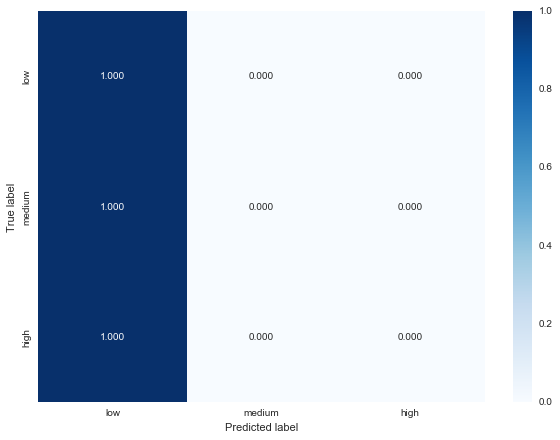

In [28]:
probabilities = np.zeros((X_test.shape[0],  3))
probabilities[:, 0] = .7
probabilities[:, 1] = .22
probabilities[:, 2] = .08
print("Log Loss: {0:.4f}".format(log_loss(y_test, probabilities)))
predictions = y_test.apply(lambda x: 'low')
print("Accuracy: {0:.4f}".format(accuracy_score(y_test, predictions)))
cm = confusion_matrix(y_test, predictions, labels = ['low', 'medium', 'high'])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = ['low', 'medium', 'high'], columns = ['low', 'medium', 'high'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.3f', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Base Model

In [29]:
base_features_to_use = ['bathrooms', 'bedrooms', 'price']

Log Loss: 0.7257
Accuracy: 0.6962


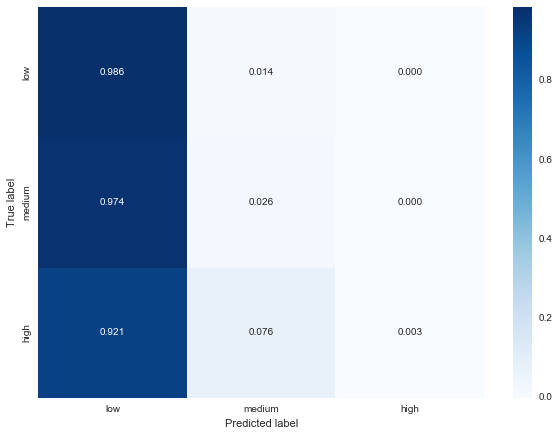

In [32]:
basic_logreg = LogReg()
basic_logreg.fit(X_train[base_features_to_use], y_train.values)
model_results(basic_logreg, X_test[base_features_to_use], y_test)

# Base Model Grid Search

In [33]:
lr = LogReg()
parameters = {'solver' : ['newton-cg', 'lbfgs'], 'multi_class' : ['ovr', 'multinomial'],
              'class_weight' : ['balanced', None], 'C' : [10**c for c in range(-7, 8)]}
lr_cv = GridSearchCV(lr, parameters, scoring = "log_loss", cv = 5, error_score = 100)
lr_cv.fit(X_train[base_features_to_use], y_train)
lr_grid_scores = lr.grid_scores_

C:\Users\Ihsaan Patel\Anaconda2\lib\site-packages\scipy\optimize\linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Ihsaan Patel\Anaconda2\lib\site-packages\sklearn\utils\optimize.py:193: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[mean: -1.03741, std: 0.00386, params: {'multi_class': 'ovr', 'C': 1e-07, 'solver': 'newton-cg', 'class_weight': 'balanced'},
 mean: -1.03890, std: 0.00315, params: {'multi_class': 'ovr', 'C': 1e-07, 'solver': 'lbfgs', 'class_weight': 'balanced'},
 mean: -1.03577, std: 0.00394, params: {'multi_class': 'multinomial', 'C': 1e-07, 'solver': 'newton-cg', 'class_weight': 'balanced'},
 mean: -1.04008, std: 0.00429, params: {'multi_class': 'multinomial', 'C': 1e-07, 'solver': 'lbfgs', 'class_weight': 'balanced'},
 mean: -0.74131, std: 0.00193, params: {'multi_class': 'ovr', 'C': 1e-07, 'solver': 'newton-cg', 'class_weight': None},
 mean: -0.74287, std: 0.00233, params: {'multi_class': 'ovr', 'C': 1e-07, 'solver': 'lbfgs', 'class_weight': None},
 mean: -0.74135, std: 0.00199, params: {'multi_class': 'multinomial', 'C': 1e-07, 'solver': 'newton-cg', 'class_weight': None},
 mean: -0.74189, std: 0.00233, params: {'multi_class': 'multinomial', 'C': 1e-07, 'solver': 'lbfgs', 'class_weight': None},


Log Loss: 0.7237
Accuracy: 0.6976


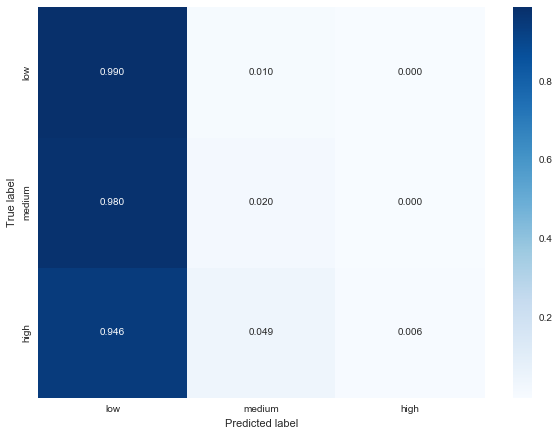

In [34]:
lr_best = lr_cv.best_estimator_
lr_best.fit(X_train[base_features_to_use], y_train)
model_results(lr_best, X_test[base_features_to_use], y_test)

# Random Forest

In [36]:
rf = RandomForestClassifier()
rf_parameters = {'n_estimators': [10, 50, 100, 250, 500], 'criterion': ['gini', 'entropy'], 
                 'max_features' : ['auto', 'sqrt', 'log2'], 'min_samples_leaf' : [1, 10, 20, 50, 100], 
                'random_state': [42], 'class_weight' : [None, 'balanced', 'balanced_subsample']}
rf_cv = GridSearchCV(rf, rf_parameters, scoring = "log_loss", cv = 5, error_score = 100)
rf_cv.fit(X_train[base_features_to_use], y_train)
rf_grid_scores = rf_cv.grid_scores_

Log Loss: 0.6972
Accuracy: 0.7074


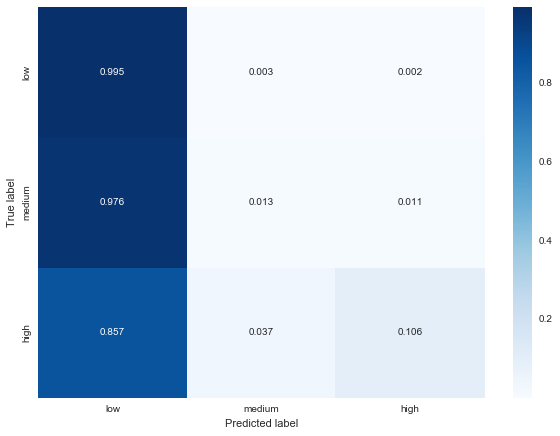

In [37]:
rf_best = rf_cv.best_estimator_
rf_best.fit(X_train[base_features_to_use], y_train)
model_results(rf_best, X_test[base_features_to_use], y_test)